# Chapter 4 -- Mode-Locking

In this recitation we will discuss laser mode-locking for ultrafast pulse generation.  We will focus on the basics of mode-locking to develop clearr mental pictures of the most important underlying processes.  We have developed simplified simulations to help better visualize and understand the mode-locking process.

This recitation will specifically cover the following topics:

1. Mode-locking
   + Difference between locked and unlocked cavity modes and importance to ultrafast pulse formation
   + Build on intuition from Fabry-Perot resonator
   + Introduction of master equation
2. Example 1: Active mode-locking
   + Experimental setup and master equation for active mode-locking
   + Introduction to simulation and assumptions
   + Overview of example simulation and results
3. Example 2: Passive mode-locking with fast saturable absorber
   + Introduction of fast saturable absorber element and how it is modeled
   + Discussion of how this enables passive mode-locking
   + Introduction of gain saturation in our model and why it is important
   + Discussion of dispersion effects and how they could be incorporated

## Packages, Functions and Variables

The following code-block contains the packages, functions and variables needed for the code found later in this notebook.  It must be run first.  Note that if you are running this on your personal computer, you should ensure that all packages needed are installed first (for example the [numpy](https://numpy.org/), [scipy](https://scipy.org/), and [matplotlib](https://matplotlib.org/) packages must be installed on your computer along with others).  You can find a launcher link at the top to conveniently run this notebook in Google Colab.  

The code below is hidden by default, but you are encouraged to expand it and study it.  The functions and constants will update as needed during the progression of the course, so you should note what new functions have been and added and study how they work.  

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import h5py
from scipy import signal
from scipy.interpolate import UnivariateSpline 

# Import the matplotlib animation tools
# as well as the html tools for creating
# javascript animations
from matplotlib import animation, rc
from IPython.display import HTML

#-- Export Settings --
# If on, then it applies a few tweaks to make sure the export looks good
want_export=False

#--Physical Constants--
hbar = 1.054e-34 #normalized Planck constant [J*s]
evcon = 1.602e-19 #conversion factor, [J/eV]
eta = 119.91699832*np.pi #impedance of freespace [ohms]
me = 9.10938188e-31 #mass of electron [kg]
c = 2.99792458e8 #speed of light [m/s]
e = 1.602e-19 #electron charge [C]

#--Gaussian Pulse Function --
def gaussian_pulse(t, fwhm, wc, phi_ce):
    """
    [E, A] = gaussian_pulse(t, fwhm, wc, phi_ce)

    Function for generating a Gaussian pulse form with given intensity FWHM.
    Outputs electric field profile and intensity envelope, both normalized to
    peak of 1.  Units need to be self-consistent between t, fwhm, and wc.

    Inputs:
    -----------
      t --> time 
      fwhm --> full width at half max of the intensity envelope
      wc --> central frequency (rad/unit time)
      phi_ce --> carrier envelope phase offset (rad)

    Outputs:
    -------------
      pulse['E'] --> Electric field profile (peak of 1)
      pulse['A'] --> Intensity envelope (peak of 1)
    
    """


    #Now determine constant for gaussian envelope from fwhm:
    tau = fwhm/(2*np.sqrt(np.log(2)));

    #Finally, define the pulse:
    E_envelope = np.exp(-t**2/(2*tau**2));
    
    pulse = {}

    pulse['E'] = E_envelope*np.cos(wc*t + phi_ce);

    pulse['A'] = E_envelope**2;
    
    return pulse

#Calculate index based on Sellmeier coefficients
# -- Assumes wavelength in microns
def n_sell(y, B, C):
    """
    Calculate index based on Sellmeier coefficients.
    
    Assumes wavelength y in microns.
    
    B and C should be vectors with equal number of coefficients.
    
    Based on forumlation here: https://en.wikipedia.org/wiki/Sellmeier_equation
    """
    
    n2 = np.ones(y.size)
    
    #We are only concerned with wavelengths > 0!
    y_valid = np.where(y > 0)
    
    for m in range(0, len(B)):
        
        n2[y_valid[0]] = n2[y_valid[0]] + B[m]*y[y_valid[0]]**2/(y[y_valid[0]]**2 - C[m])
        
    n = np.sqrt(np.abs(n2))
    
    return n


def split_step(A0, z, f, dt, beta2, beta3, gamma):
    """
    This function carries out the split step procedure 
    to calculate a pulse spectra propagating through the NLSE. The
    split-step implementation here is not optimized in any way. (I'd say
    that it's relatively inefficient.) This function does not use a
    normalized NLSE. (4-21-20).
    
    INPUTS: 
        A0      sqrt(W):    input pulse
        z       mm:         spatial grid to propagate over (uniformly sampled)
        f       PHz:        frequency span for FFTs (defined by t)
        dt      fs:         temporal spacing 
        beta2   fs^2/mm:    GVD
        beta3   fs^3/mm:    TOD
        gamma   1/(W*mm):   nonlinear coeff.
 
    OUTPUTS:
        A   time signal out
        A_f frequency signal out
    """

    Nz = z.size
    
    #z should be uniformly sampled
    dz = z[1]-z[0]

    # initialize 
    A = np.zeros( (Nz, A0.size)) + 0j
    A_f = np.zeros( (Nz, A0.size) ) + 0j
    A[0, :] = A0
    A_f[0, :] = dt*np.fft.fft(A0);

    #calculate all the traces and spectra
    for co in range(1,Nz):
        #spectrum calculation
        Atemp_f = dt * np.exp(-1j/4*beta2*(2*np.pi*f)**2*dz + 1j/12*beta3*(2*np.pi*f)**3*dz)*\
        np.fft.fft( np.exp(-1j*gamma*np.abs(A[co-1, :])**2*dz)*\
        np.fft.ifft( np.exp(-1j/4*beta2*(2*np.pi*f)**2*dz + 1j/12*beta3*(2*np.pi*f)**3*dz)*\
        np.fft.fft( A[co-1, :] ) ) );

        #assignments
        A_f[co, :] = Atemp_f;
        A[co, :] = 1/dt*np.fft.ifft(Atemp_f);
    
    
    return A, A_f

def active_ml(t, A0, omega_M, M, g, l, omega_g, dT, NT, N_save = 1):
    """
    Calculates the evolution of a seed wave in a resonator with a driven
    loss element to simulate active mode-locking.  This follows the Haus
    master equation as described in H. Haus, “A theory of forced mode locking,” 
    IEEE Journal of Quantum Electronics, vol. 11, no. 7, pp. 323–330, 
    Jul. 1975, doi: 10.1109/JQE.1975.1068636.
    
    All time units below are relative and set by the units of the time
    axis t.
    
    Inputs:
        t         time axis (denotes envelope over time duration of one round trip)
        A0        Initial envelope
        omega_M   Modulation frequency
        M         Modulation strength
        g         Peak gain
        l         loss coefficient (per round trip)
        omega_g   Gain bandwidth (approximated by parabola)
        dT        Step duration (tyically set to T_R, round trip time)
        NT        Number of steps to move forward (round trips if dT=T_R)
        N_save    Number of steps to go before recording the current state of
                  A in the cavity to A_out.

        
    Outputs:
        A_out     Output envelope.  Matrix of floor(NT/N_save) rows, 
                  and length t columns.
        
    """
    dt = t[1] - t[0]
    T_R = t[-1] - t[0]
    
    N_out = int(np.floor(NT/N_save))
    
    A_out = np.zeros((N_out, A0.size)) + 0j
    A_current = A0
    A_out[0, :] = A0
    
    n_out = 0
    for co in range(1, NT):
        
        A_m1 = A_current
        A_m1_pp = np.diff(np.diff(A_m1)/dt)/dt
        A_m1_pp = np.append(A_m1_pp, A_m1_pp[-1])
        A_m1_pp = np.append(A_m1_pp, A_m1_pp[-1])
        
        #Take care to window in frequency -- if you don't high-frequency components can run out of control.
        #These are unphysical and can be ignored.
        A_current = np.fft.ifft(np.fft.fftshift(signal.tukey(t.size, 0.5))*\
                               np.fft.fft((A_m1 + dT*((g - l)*A_m1 + \
                                                      (g/(omega_g**2))*A_m1_pp - \
                                                      M*(1 - np.cos(omega_M*t))*A_m1)/T_R)))
        
        if(np.mod(co, N_save) == 0):
            n_out = n_out + 1
            A_out[n_out, :] = A_current
        
        
    return A_out

def fast_sa_ml(t, A0, g0, W_sat, l, omega_g, s0, I_sat, dT, NT, N_save = 1):
    """
    Calculates the evolution of a seed wave in a resonator with a fast
    saturable absorber element to simulate passive mode-locking.  
    
    All time units below are relative and set by the units of the time
    axis t.
    
    Inputs:
        t         time axis (denotes envelope over time duration of one round trip)
        A0        Initial envelope
        g0        Small-signal gain
        W_sat     Gain saturation energy
        l         loss coefficient (per round trip)
        omega_g   Gain bandwidth (approximated by parabola)
        s0        Unsaturated loss
        I_sat     Saturation intensity
        dT        Step duration (tyically set to T_R, round trip time)
        NT        Number of steps to move forward (round trips if dT=T_R)
        N_save    Number of steps to go before recording the current state of 
                  A in the cavity to A_out.
        
    Outputs:
        A_out     Output envelope.  Matrix of floor(NT/N_save) rows, 
                  and length t columns.
        
    """
    dt = t[1] - t[0]
    T_R = t[-1] - t[0]
    
    N_out = int(np.floor(NT/N_save))
    
    A_out = np.zeros((N_out, A0.size)) + 0j
    A_current = A0
    A_out[0, :] = A0
    
    n_out = 0
    for co in range(1, NT):
        
        A_m1 = A_current
        A_m1_pp = np.diff(np.diff(A_m1)/dt)/dt
        A_m1_pp = np.append(A_m1_pp, A_m1_pp[-1])
        A_m1_pp = np.append(A_m1_pp[0], A_m1_pp)
        
        W_pulse = np.trapz(np.abs(A_m1)**2)*dt
        g = g0/(1 + W_pulse/W_sat)
        
        #Take care to window in frequency -- if you don't high-frequency components can run out of control.
        #These are unphysical and can be ignored.
        A_current = np.fft.ifft(np.fft.fftshift(signal.tukey(t.size, 0.5))*\
                               np.fft.fft((A_m1 + dT*((g - l)*A_m1 + \
                                                      (g/(omega_g**2))*A_m1_pp - \
                                                      (s0/(1 + np.abs(A_m1)**2/I_sat))*A_m1)/T_R)))
        
        if(np.mod(co, N_save) == 0):
            n_out = n_out + 1
            A_out[n_out, :] = A_current
        
        
    return A_out
    
    

## 5.1 Mode-Locking

In recitation 1 we discussed how the sumation of many harmonic orders of electromagnetic radiation leads to the formation of ultrafast pulse trains.  If each harmonic order has the same phase, then the resulting pulse train is said to be "transform-limited" in that each pulse is as short as possible given the available bandwidth.  In this condition, the inclusion of more and more harmonic orders lead to shorter and shorter pulse durations, with the repetition rate being the period of the fundamental harmonic.  Conversely, when each harmonic has a random phase (that is the phases are not locked together), then the resultant radiation does not form a pulse train, but rather a fluctiating signal with a constant time-averaged power. Thus, **the primary goal of any ultrafast, pulsed laser source design is to reliably generate a broad comb of harmonic modes with locked phases.**

Optical cavities can be designed to support many equally spaced modes in frequency of equal spacing dictated by the round trip time of optical radiation in the cavity.  Recall for instance the Fabry-Perot cavity which is the simplest example.  If one places a gain medium between both mirrors of  the cavity, then each of these modes has the potential to be amplified depending on the gain bandwdith of the gain medium and/or the cavity elements.  However, there is no natural reason for this basic cavity with a gain element to generate modes with locked phases.  To achieve that, we need a time-dependent modulation element.

Periodic modulations of a signal in time lead to side-bands in the frequency space.  If the modulation period is once per round trip, then information is passed between each mode and its neighbors.  Together with the gain medium and cavity, this modulation element can result in a feedback process that results in stable solutions of the cavity modes that are locked together in phase resulting in short pulse trains.  

To simulate this process, a "master equation" is often used that calculates the impact of each element on the time-domain envelope of the radiation within the cavity over one round trip.  Stable solutions are those that return to the same envelope function after one complete round trip.  We often use two different timescales for this: one is a long time-scale denoted by $T$ which evolves slowly over one or many round trips, and the other is the fast time-scale $t$ which denotes the instantaneous envelope function.  

A simplified master equation might be written as follows: 

$\Delta A(T, t) = T_R \frac{\partial A(T, t)}{\partial T} = g A(T, t) + \frac{g}{\omega_g^2} \frac{\partial^2 A(T, t)}{\partial t^2} - l A(T, t) -  M(t) A(T, t)$

where $\Delta A(T, t)$ is the change in $A(T, t)$ over one round trip, $T_R$ is the round trip time, $g$ the gain per round-trip, $l$ the loss per round trip, $\omega_g$ the gain bandwidth (approximated as having a parabolic shape), and $M(t)$ the modulation function in time.  Note that any of these terms could depend on the current intensity in the cavity due to variousu saturation effects or nonlinearities.  We will see this come into play in our fast saturable absorber example. Finally, note that we have not included dispersion and nonlinear propagation effects (*e.g.* self-phase modulation) here.  Tese become important as the pulse durations are pushed shorter and shorter.  

It is useful to explain each part of the right hand side:

 1. $g A(T, t) + \frac{g}{\omega_g^2} \frac{\partial^2 A(T, t)}{\partial t^2}$: this part accounts for the instantaneous change per trip due to gain, accounting for gain bandwidth (assuming a parabolic spectral profile).  As an exercise, take the Fourier transform of this part with respect to $t$ to see how it accounts for the bandwidth. 
 2. $- l A(T, t) -  M(t) A(T, t)$: this part accounts for the losses -- both static and those created by the modulator which are dynamic, $M(t)$.  Note that no bandwidth is considered as this could be effectively wrapped into the gain expression as a modification of $\omega_g$.  

In the following we will explore simulations of this master equation by examining two important mode-locked cavity designs.  First, the active mode-locking design which uses an externally controlled, electrically-driven modulator element.  Second, passive mode-locking with a fast saturable absorber, which exploits modulation due to an element whose absorption saturates with increased instantaneous intensity.  Note that in our function collection, we have now added two new functions, `active_ml`, and `fast_sa_ml` which model the evolution of the amplitude function $A(T, t)$ per round trip for each case.    To achieve this, we solve the master equation numerically.  We start at the initial state $A(0, t)$, and then step forward one round trip at a time computing $\Delta A(T, t)$ by calculating each term on the right hand side.  We then find $A(T_R, t) = A(0, t) + \Delta A(T_R, t)$.  From there we proceed iteratively, finding $A(nT_R, t) = A((n-1)T_R, t) + \Delta A(nT_R, t)$.  

For further reference aside from the recommended course texts, see [H. Haus, “A theory of forced mode locking,” IEEE Journal of Quantum Electronics, vol. 11, no. 7, pp. 323–330, Jul. 1975, doi: 10.1109/JQE.1975.1068636.](https://drive.google.com/file/d/1cc8JYW_XdgxpYludhoCQeu_z49gGmqcQ/view?usp=sharing) for one of the original references on active mode locking, and [F. X. Kartner, J. A. der Au, and U. Keller, “Mode-locking with slow and fast saturable absorbers-what’s the difference?,” IEEE Journal of Selected Topics in Quantum Electronics, vol. 4, no. 2, pp. 159–168, Mar. 1998, doi: 10.1109/2944.686719](https://drive.google.com/file/d/1cc8JYW_XdgxpYludhoCQeu_z49gGmqcQ/view?usp=sharing).   


## 5.2 Example 1: Active Mode-Locking

For active mode-locking we have a driven $M(t) = M[1 + \cos(\omega_M t)]$.  Note that it is required that $0 \leq M \leq 1$. Such a modulation could be achieved through the use of electro-optics or acousto-optics.  When this function has a minimum, the cavity is set up in such a way that the gain temporarily exceeds the losses over a brief window.  The cavity then preferentially amplifies radiation in this window.  Pulses build until there is a balance between the gain, gain bandwidth, and losses such that after one round trip the pulse repeats itself.  For sinusoidal modulations driven synchronously with one round trip of the laser, the solutions are Gaussian pulses in time/frequency.  

This technique is limited in the ultimate pulse duration due to limitations on the frequency and strenght of modulation that can be achieved.  Also note that the existence of a solution to the cavity does not remark on its stability under realistic perturbation.  It turns out that when increasing the gain bandwidth, one finds that the cavity will converge to a collection of pulses of the gain region when starting from a random seed.  This is why actively mode-locked systems typically employ a bandpass filter inside the cavity to artificially limit the gain bandwidth for stability.  

In the following code, we numerically explore an actively mode-locked system.  We start with a selection of parameters for the master equation.  We then provide a random seed pulse to the system and watch it evolve over many thousands of round trips.  Finally, we track the mode contributions at each harmonic of the round trip time to watch how this random seed pulse, with random amplitudes and phases, becomes mode-locked leading to a short pulse train output.  

On your own, try changing the settings.  What happens as you keep increasing $\omega_g$?  What are the impacts of the gain $g$ and loss $l$ on the output pulse?  

### System Settings

Interactive script for easily inputting all desired settings for the actively mode-locked cavity.  All variable names derived from the related equations introduced above. 

In [20]:
# -- Default Settings --

#Gain Medium
omega_g = 10
l = 0.1e-6
g = 1e-6

#Modulator
M = 0.005

#Cavity
T_R = 1.0 # Round-trip time in nanoseconds

#Simulation
Nt = 1000
NT = 40000 #No. of round trips to simulate

fig = plt.figure()
fig.set_size_inches(20, 3.5)

# -- Calculations --
def update(g, omega_g, l, M, T_R, Nt, NT, fig):

    #Setup the time-base
    t = np.linspace(-T_R/2.0, T_R/2.0, Nt)
    dt = t[1] - t[0]
    f = np.fft.fftfreq(t.size, dt)

    #Make an initial random pulse
    # -- Make sure to time-window it so you don't get spurious frequency components
    phase = np.random.rand(f.size)*2*np.pi
    A0_f = np.exp(-1*f**2*1/omega_g**2)*np.exp(1j*phase) + 0*1j
    A0 = np.fft.fftshift((np.fft.ifft(A0_f)))*np.cos(np.pi*t/2/t[-1])**2

    #Calculate Modulation Frequency
    omega_M = 2*np.pi/T_R

    #Calculate losses with modulation
    losses = l + M*(1 - np.cos(omega_M*t))
    
    ax1 = []
    ax2 = []
    ax3 = []
    axes = fig.get_axes()
    if(len(axes)==0):
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
    else:
        ax1 = axes[0]
        ax2 = axes[1]
        ax3 = axes[2]

    ax1.cla()
    ax1.plot(t, losses)
    ax1.axhline(g, color='tab:red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Losses/Gain')
    ax1.set_title('Gains vs. Losses')
    
    ax2.cla()
    ax2.plot(t, losses)
    ax2.axhline(g, color='tab:red')
    ax2.set_ylim(0, g*1.2)
    ax2.set_xlim(-0.1, 0.1)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Losses/Gain')
    ax2.set_title('Gains vs. Losses')
    
    ax3.cla()
    ax3.plot(t, np.abs(A0)**2)
    ax2.set_xlabel('Time')
    ax3.set_ylabel('Intensity (arb. units)')
    ax3.set_title('Seed Pulse')
    
    display(fig)        
    
    return t, dt, f, A0, M, omega_M, l, g, omega_g, T_R, Nt, NT

system_set = ipywidgets.interactive(update, 
                                    g=ipywidgets.FloatText(value=g, description='g'),
                                    omega_g=ipywidgets.FloatText(value=omega_g, description='omega_g'),
                                    l=ipywidgets.FloatText(value=l, description='l'),
                                    M=ipywidgets.FloatText(value=M, description='M'),
                                    T_R=ipywidgets.FloatText(value=T_R, description='T_R'),
                                    Nt=ipywidgets.IntText(value=Nt, description = 'Nt'),
                                    NT=ipywidgets.IntText(value=NT, description = 'NT'),
                                    fig=ipywidgets.fixed(fig))

button = ipywidgets.Button(description='Regenerate Seed')
button.on_click(system_set.update)


display(system_set, button)

if want_export:
    display(fig)

interactive(children=(FloatText(value=1e-06, description='g'), FloatText(value=10.0, description='omega_g'), F…

<Figure size 2000x350 with 0 Axes>

Button(description='Regenerate Seed', style=ButtonStyle())

### Run the System

Runs the system for the desired number of iterations and collects 100 output traces of A in the cavity into A_out over that time.  For example, if you want to run for `NT = 1000` steps, you would record an output every 10 steps.  

Text(0, 0.5, 'round trips')

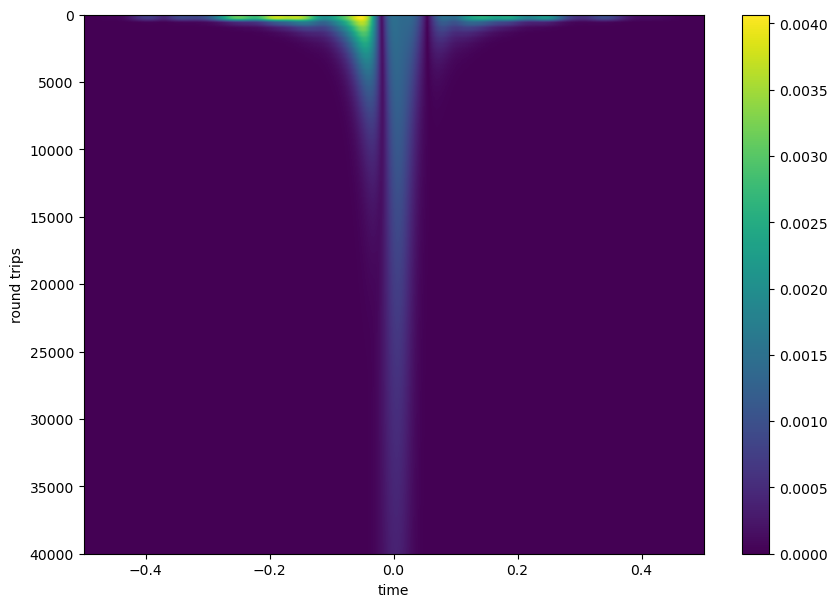

In [21]:
t, dt, f, A0, M, omega_M, l, g, omega_g, T_R, Nt, NT = system_set.result

dT = T_R
N_save = NT/100


A = active_ml(t, A0, omega_M, M, g, l, omega_g, dT, NT, N_save=N_save)

fig = plt.figure()
fig.set_size_inches(10, 7)
extent = [t[0], t[-1], NT, 0]
plt.imshow(np.abs(A), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel('time')
plt.ylabel('round trips')

### Final Spectrum

Plot the final pulse spectrum after `NT` iterations.

/tmp/ipykernel_3925163/2339460081.py:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.fft.fftshift(f),


Text(0, 0.5, 'intensity')

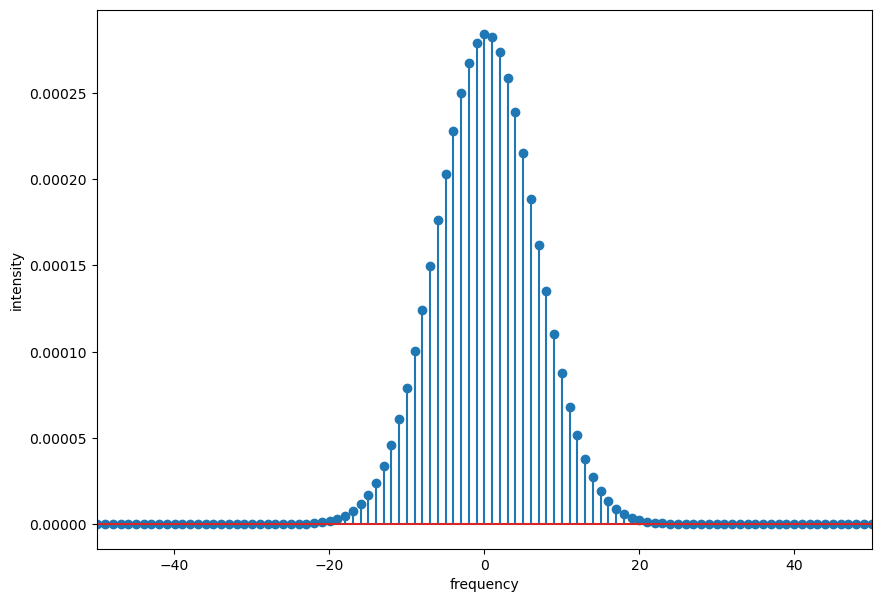

In [22]:
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.stem(np.fft.fftshift(f), 
         (np.fft.fftshift((np.abs(np.fft.fft(np.fft.fftshift(A[-1, :]))))))**2,
        use_line_collection=True)
plt.xlim(-50, 50)
plt.xlabel('frequency')
plt.ylabel('intensity')

### Final Spectral Phase

Plot the phase of the final spectrum after `NT` steps.

/tmp/ipykernel_3925163/2545226704.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.fft.fftshift(f[frange[0]]),


Text(0, 0.5, 'phase (rad)')

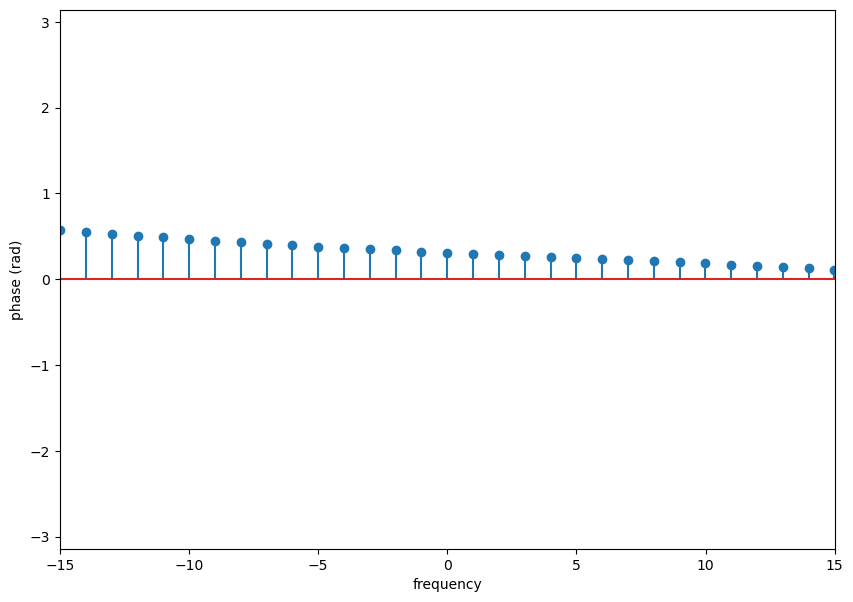

In [23]:
N_plot = 15

fig = plt.figure()
fig.set_size_inches(10, 7)

frange = np.where(np.abs(f)  <= N_plot)

plt.stem(np.fft.fftshift(f[frange[0]]), 
         (np.fft.fftshift((np.angle(np.fft.fft(np.fft.fftshift(A[-1, :]))))[frange[0]])),
        use_line_collection=True)
plt.xlim(-N_plot, N_plot)
plt.ylim(-np.pi, np.pi)
plt.xlabel('frequency')
plt.ylabel('phase (rad)')

### Final Time-Domain Intensity

Plot the final time-domain intensity of `A` after `NT` steps.

Text(0, 0.5, 'intensity')

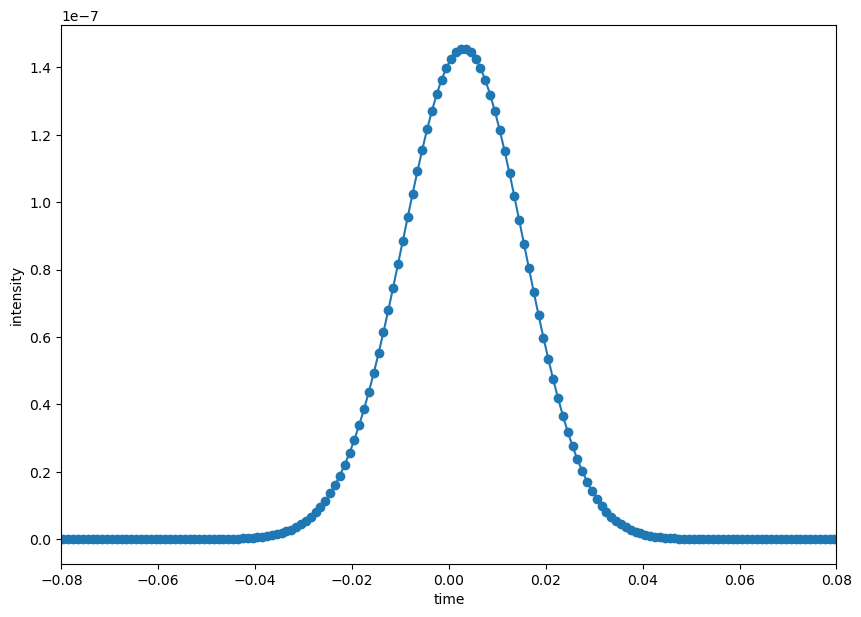

In [24]:
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(t, np.abs(A[-1, :])**2, 'o-')
plt.xlim(-0.08, 0.08)
plt.xlabel('time')
plt.ylabel('intensity')

### Animation of Pulse Formation

It can be useful to study an animation of the pulse as it develops in the cavity.  You can compare this to the fast saturable absorber example below.  Slowly watch how the pulse evolves. 

You can manually move the cursor to examine things more closely, and you can also yous the `-` and `+` buttons to slow down/speed up the animation. 

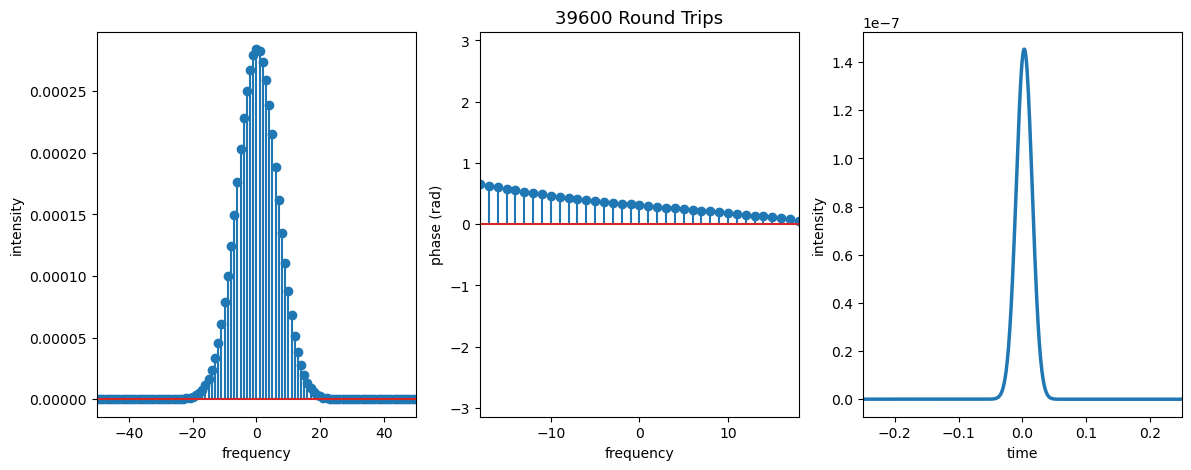

In [25]:
fig = plt.figure()
fig.set_size_inches(14, 5)

ax_amp = fig.add_subplot(1, 3, 1)
markerline, stemlines, baseline = ax_amp.stem(np.fft.fftshift(f), 
                                              (np.fft.fftshift((np.abs(np.fft.fft(np.fft.fftshift(A[0, :]))))))**2)
ax_amp.set_xlim(-25, 25)
ax_amp.set_xlabel('frequency')
ax_amp.set_ylabel('intensity')

N_plot = 18
frange = np.where(np.abs(f)  <= N_plot)
ax_phase = fig.add_subplot(1, 3, 2)
markerline_phase, stemline_phase, baseline_phase = ax_phase.stem(np.fft.fftshift(f[frange[0]]), 
                                                                 (np.fft.fftshift((np.angle(np.fft.fft(np.fft.fftshift(A[0, :]))))[frange[0]])))
ax_phase.set_xlim(-N_plot, N_plot)
ax_phase.set_ylim(-np.pi, np.pi)
ax_phase.set_xlabel('frequency')
ax_phase.set_ylabel('phase (rad)')

ax_time = fig.add_subplot(1, 3, 3)
line, = plt.plot(t, np.abs(A[0, :])**2, '-', linewidth=2.5)
ax_time.set_xlim(-.25, 0.25)
ax_time.set_xlabel('time')
ax_time.set_ylabel('intensity')

N = 100
bottom=0
def updatefig(i):
    
    ax_amp.cla()
    markerline, stemlines, baseline = ax_amp.stem(np.fft.fftshift(f), 
                                                  (np.fft.fftshift((np.abs(np.fft.fft(np.fft.fftshift(A[i, :]))))))**2)
    ax_amp.set_xlim(-50, 50)
    ax_amp.set_xlabel('frequency')
    ax_amp.set_ylabel('intensity')
    
    ax_phase.cla()
    markerline_phase, stemline_phase, baseline_phase = ax_phase.stem(np.fft.fftshift(f[frange[0]]), 
                                                                     (np.fft.fftshift((np.angle(np.fft.fft(np.fft.fftshift(A[i, :]))))[frange[0]])))
    ax_phase.set_xlim(-N_plot, N_plot)
    ax_phase.set_ylim(-np.pi, np.pi)
    ax_phase.set_title(str(int(i*N_save)) + ' Round Trips', fontsize=13)
    ax_phase.set_xlabel('frequency')
    ax_phase.set_ylabel('phase (rad)')

    
    ax_time.cla()
    line, = plt.plot(t, np.abs(A[i, :])**2, '-', linewidth=2.5)
    ax_time.set_xlim(-0.25, 0.25)
    ax_time.set_xlabel('time')
    ax_time.set_ylabel('intensity')
    
    return markerline, stemlines, baseline, markerline_phase, stemline_phase, baseline_phase, line

#Setup the animation
ani = animation.FuncAnimation(fig, updatefig, interval=N, blit=True)

#Convert to javascript html movie
HTML(ani.to_jshtml())

## 5.3 Example 2: Passive Mode-Locking: Fast Saturable Absorber

For passive mode-locking, we need an optical element that modulates the envelope based on its current state.  This can be achieved with a physical effect known as saturable absorption.  Various materials exhibit a reduced amound of absorption as intensity increases.  Fast saturable absorbers are those that exhibit such a decrease in absorption nearly instantaneously relative to the incident pulse duration.  When such elements are placed into the cavity, they exhibit an amplitude modulation effect that favors regions of high intensity.  In these temporal regions, the gains exceed losses leading to amplification, which proceeds generating shorter, more intense pulses. This leads to a passive mode-locking effect.

We can simulate the saturable absorber element using the following expression:

$M(t) = s_0/(1 + \frac{I(t)}{I_\text{sat}})$

where $M(t)$ is again our modulation function representing the instantaneous loss due to the saturable absorber elmeent, $s_0$ the low-intensity loss, $I(t) \propto |A(T, t)|^2$ the instantaneous intensity, and $I_sat$ the saturation intensity.  Note that for $I(t) = 0$ we have that $s = s_0$, and as $I(t)$ increases to infinity, $s$ decreases to 0.  

If we simply change $M(t)$ we would find the solution to our previous master equation is not stable.  This is because our prior master equation assumed the input of the steady-state gain (not the peak gain) of the laser system after stabilization.  This was fine because our modulation function did not depend on the intensity in the cavity, and thus would settle to the natural steady state solution without any issue.  However, here we can have a run-away response as higher intensities could keep building as the modulation function changes on each pass making it unstable.  In real life this wouldn't happen due to gain saturation, which we must model here.  So for this calculation, we instead input the peak small-signal gain for $g_0$ into our simulator as well as a new parameter $W_\text{sat}$ which is the energy saturation of the gain response, where 

$g = g_0/(1 + \frac{W_\text{cavity}}{W_\text{sat}})$

where $W_\text{cavity} = \int_{-T_R/2}^{T_R/2} \mathrm{d}t P(t)$ where $P(t) \propto I(t) \propto |A(T, t)|^2$.  Note then that as the energy in the cavity increases, the gain saturates, as it would in real life, preventing a run-away condition.  

In the following we run through the solution to a passively mode-locked system similar to what we calculated above for the active system.  The intiial conditions were chosen for demosntration, but again, you should play with these values and note how they impact the solution.

Note that such systems can achieve very short pulses (tens to hundreds of femtoseconds).  However, in such cases dispersion and self-phase modulation becomes important.  How might you extend these simulators to account for such effects?  

### System Settings

Interactive script for easily inputting all desired settings for the actively mode-locked cavity.  All variable names derived from the related equations introduced above. 

In [26]:
# -- Settings --

#Gain Medium
omega_g = 200
g0 = 0.1
W_sat = 0.0001 #Saturation energy
l = 1.0e-4

#Fast Saturable Absorber
s0 = 1e-2
I_sat = 0.002

#Cavity
T_R = 1.0 # Round-trip time in nanoseconds

#Simulation
Nt = 2000
NT = 40000 #No. of round trips to simulate

#Create the figure container
fig = plt.figure()
fig.set_size_inches(20, 3.5)

# -- Calculations --
def update(g0, W_sat, omega_g, l, s0, I_sat, T_R, Nt, NT, fig):

    #Setup the time-base
    t = np.linspace(-T_R/2.0, T_R/2.0, Nt)
    dt = t[1] - t[0]
    f = np.fft.fftfreq(t.size, dt)

    #Make an initial random pulse
    # -- Make sure to time-window it so you don't get spurious frequency components
    phase = np.random.rand(f.size)*2*np.pi
    A0_f = np.exp(-1*f**2*6/omega_g**2)*np.exp(1j*phase) + 0*1j
    A0 = np.fft.fftshift((np.fft.ifft(A0_f)))*np.cos(np.pi*t/2/t[-1])**2
    A0 = A0/np.max(np.abs(A0))

    #Calculate gain and satyurable absorber effects
    W_pulse = np.trapz(np.abs(A0)**2)*dt
    gain = g0/(1 + W_pulse/W_sat)
    losses = l + s0/(1 + np.abs(A0)**2/I_sat)
    
    ax1 = []
    ax2 = []
    ax3 = []
    axes = fig.get_axes()
    if(len(axes)==0):
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
    else:
        ax1 = axes[0]
        ax2 = axes[1]
        ax3 = axes[2]
    
    
    ax1.plot(t, losses)
    ax1.axhline(gain, color='tab:red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Losses/Gain')
    ax1.set_title('Gains vs. Losses')
    
    ax2.plot(t, losses)
    ax2.axhline(gain, color='tab:red')
    ax2.set_ylim(0, gain*1.2)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Losses/Gain')
    ax2.set_title('Gains vs. Losses')
    
    ax3.plot(t, np.abs(A0)**2)
    ax2.set_xlabel('Time')
    ax3.set_ylabel('Intensity (arb. units)')
    ax3.set_title('Seed Pulse')
    
    #Display the figure
    display(fig)

    
    return t, dt, f, A0, s0, I_sat, l, g0, W_sat, omega_g, T_R, Nt, NT

system_set_fast_sa = ipywidgets.interactive(update, 
                                    g0=ipywidgets.FloatText(value=g0, description='g0'),
                                    W_sat=ipywidgets.FloatText(value=W_sat, description='W_sat'),
                                    omega_g=ipywidgets.FloatText(value=omega_g, description='omega_g'),
                                    l=ipywidgets.FloatText(value=l, description='l'),
                                    s0=ipywidgets.FloatText(value=s0, description='s0'),
                                    I_sat=ipywidgets.FloatText(value=I_sat, description='I_sat'),
                                    T_R=ipywidgets.FloatText(value=T_R, description='T_R'),
                                    Nt=ipywidgets.IntText(value=Nt, description = 'Nt'),
                                    NT=ipywidgets.IntText(value=NT, description = 'NT'),
                                    fig=ipywidgets.fixed(fig))

button = ipywidgets.Button(description='Regenerate Seed')
button.on_click(system_set_fast_sa.update)


display(system_set_fast_sa, button)

if want_export:
    display(fig)

interactive(children=(FloatText(value=0.1, description='g0'), FloatText(value=0.0001, description='W_sat'), Fl…

<Figure size 2000x350 with 0 Axes>

Button(description='Regenerate Seed', style=ButtonStyle())

### Run the System

Runs the system for the desired number of iterations and collects 100 output traces of A in the cavity into A_out over that time.  For example, if you want to run for `NT = 1000` steps, you would record an output every 10 steps.  

Text(0, 0.5, 'round trips')

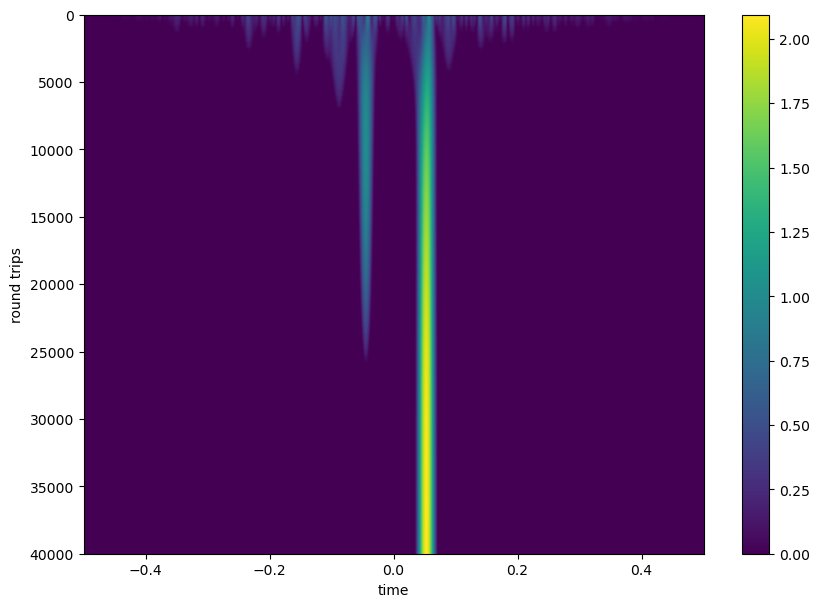

In [27]:
t, dt, f, A0, s0, I_sat, l, g0, W_sat, omega_g, T_R, Nt, NT = system_set_fast_sa.result

dT = T_R
N_save = NT/100

A = fast_sa_ml(t, A0, g0, W_sat, l, omega_g, s0, I_sat, dT, NT, N_save=N_save)

dt = t[1] - t[0]
W_pulse = np.trapz(np.abs(A)**2)*dt
g = g0/(1 + W_pulse/W_sat)

fig = plt.figure()
fig.set_size_inches(10, 7)
extent = [t[0], t[-1], NT, 0]
plt.imshow(np.abs(A), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel('time')
plt.ylabel('round trips')

### Look at Select Outputs

Here we examine outputs at the start, middle, and end of the mode-locking process.  The evolution of mode-locking can be quite a bit more complex for the case of the saturable absorber.  Why is that? 

Text(0, 0.5, 'intensity')

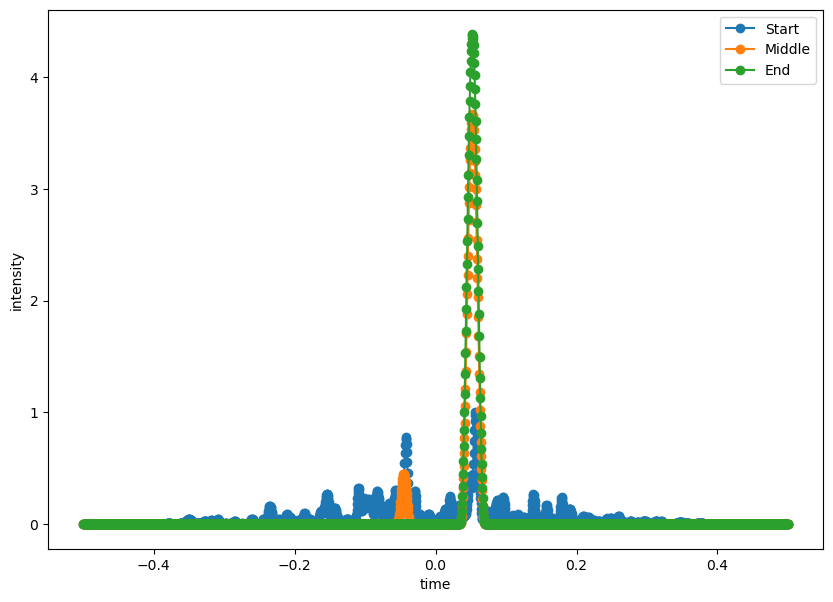

In [28]:
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(t, np.abs(A[0,:])**2, 'o-', label='Start')
plt.plot(t, np.abs(A[50, :])**2, 'o-', label='Middle')
plt.plot(t, np.abs(A[-1, :])**2, 'o-', label='End')
plt.legend()
plt.xlabel('time')
plt.ylabel('intensity')

# plt.xlim(-0.08, 0.08)

### Mode-Locking Animation

Now, like before, we track the pulse as a function of round trips.  This time, however, we have added an extra tracker for the gain as it also changes dynamically.  Note that the gain first shoots up before settling to its steady-state value.  Why do you think this happens? 

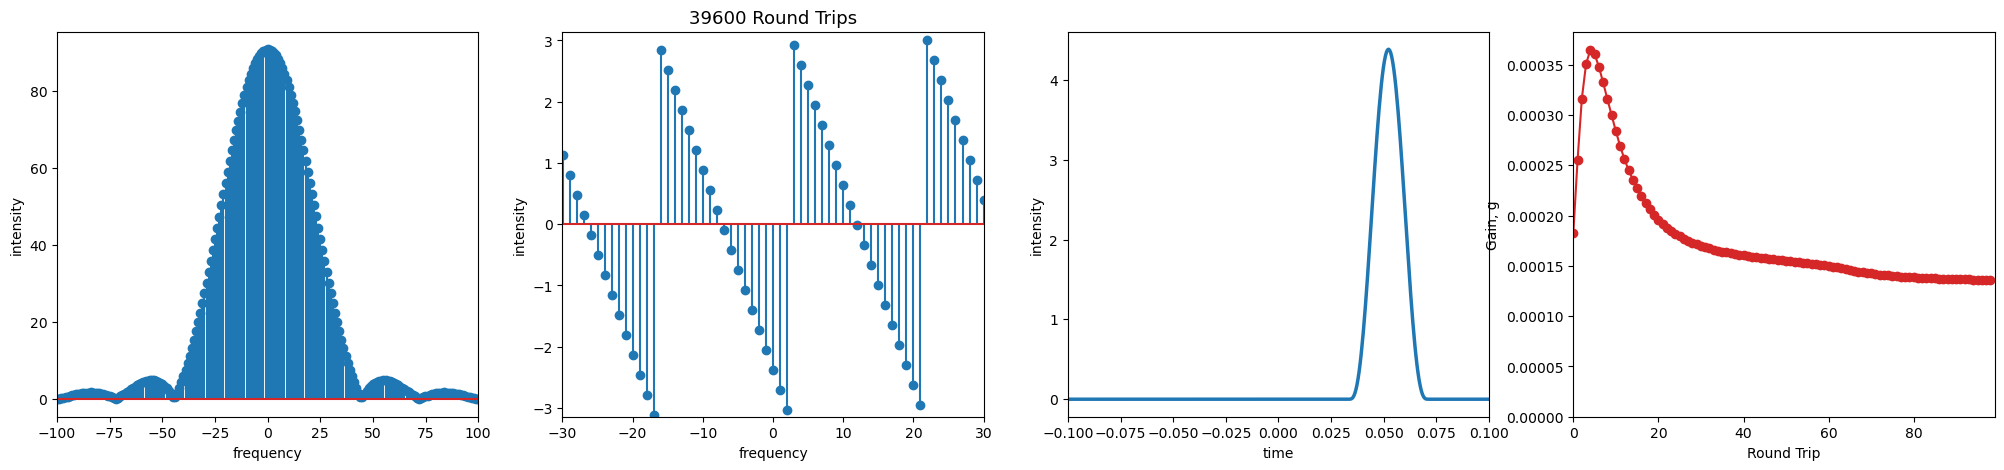

In [29]:
fig = plt.figure()
fig.set_size_inches(25, 5)

ax_amp = fig.add_subplot(1, 4, 1)
markerline, stemlines, baseline = ax_amp.stem(np.fft.fftshift(f), 
                                              (np.fft.fftshift((np.abs(np.fft.fft(np.fft.fftshift(A[0, :])))))))
ax_amp.set_xlim(-50, 50)

N_plot = 30
frange = np.where(np.abs(f)  <= N_plot)
ax_phase = fig.add_subplot(1, 4, 2)
markerline_phase, stemline_phase, baseline_phase = ax_phase.stem(np.fft.fftshift(f[frange[0]]), 
                                                                 (np.fft.fftshift((np.angle(np.fft.fft(np.fft.fftshift(A[0, :]))))[frange[0]])))
ax_phase.set_xlim(-N_plot, N_plot)
ax_phase.set_ylim(-np.pi, np.pi)


ax_time = fig.add_subplot(1, 4, 3)
line, = ax_time.plot(t, np.abs(A[0, :])**2, '-', linewidth=2.5)
ax_time.set_xlim(-.1, 0.1)

ax_gain = fig.add_subplot(1, 4, 4)
line_gain, = ax_gain.plot(0, g[0], 'o-', color='tab:red')
ax_gain.set_xlim(0, 99)
ax_gain.set_xlabel('Round Trip')
ax_gain.set_ylabel('Gain, g')

N = 100
bottom=0
def updatefig(i):
    ax_amp.cla()
    markerline, stemlines, baseline = ax_amp.stem(np.fft.fftshift(f), 
                                                  (np.fft.fftshift((np.abs(np.fft.fft(np.fft.fftshift(A[i, :])))))))
    ax_amp.set_xlim(-100, 100)
    ax_amp.set_xlabel('frequency')
    ax_amp.set_ylabel('intensity')
    
    ax_phase.cla()
    markerline_phase, stemline_phase, baseline_phase = ax_phase.stem(np.fft.fftshift(f[frange[0]]), 
                                                                (np.fft.fftshift((np.angle(np.fft.fft(np.fft.fftshift(A[i, :]))))[frange[0]])))
    ax_phase.set_xlim(-N_plot, N_plot)
    ax_phase.set_ylim(-np.pi, np.pi)
    ax_phase.set_title(str(int(i*N_save)) + ' Round Trips', fontsize=13)
    ax_phase.set_xlabel('frequency')
    ax_phase.set_ylabel('intensity')
    
    ax_time.cla()
    line, = ax_time.plot(t, np.abs(A[i, :])**2, '-', linewidth=2.5)
    ax_time.set_xlim(-0.1, 0.1)
    ax_time.set_xlabel('time')
    ax_time.set_ylabel('intensity')
    
    ax_gain.cla()
    line_gain, = ax_gain.plot(range(0,i), g[0:i], 'o-', color='tab:red')
    ax_gain.set_xlim(0, 99)
    ax_gain.set_ylim(0.0, 1.05*np.max(g))
    ax_gain.set_xlabel('Round Trip')
    ax_gain.set_ylabel('Gain, g')
    
    return markerline, stemlines, baseline, markerline_phase, stemline_phase, baseline_phase, line, line_gain

#Setup the animation
ani = animation.FuncAnimation(fig, updatefig, interval=N, blit=True)

#Convert to javascript html movie
HTML(ani.to_jshtml());

### Gain Dynamics at Stable Operating Point

Here we re-plot the loss/gain dynamics at the final operating point for reference.

Text(0.5, 1.0, 'Seed Pulse')

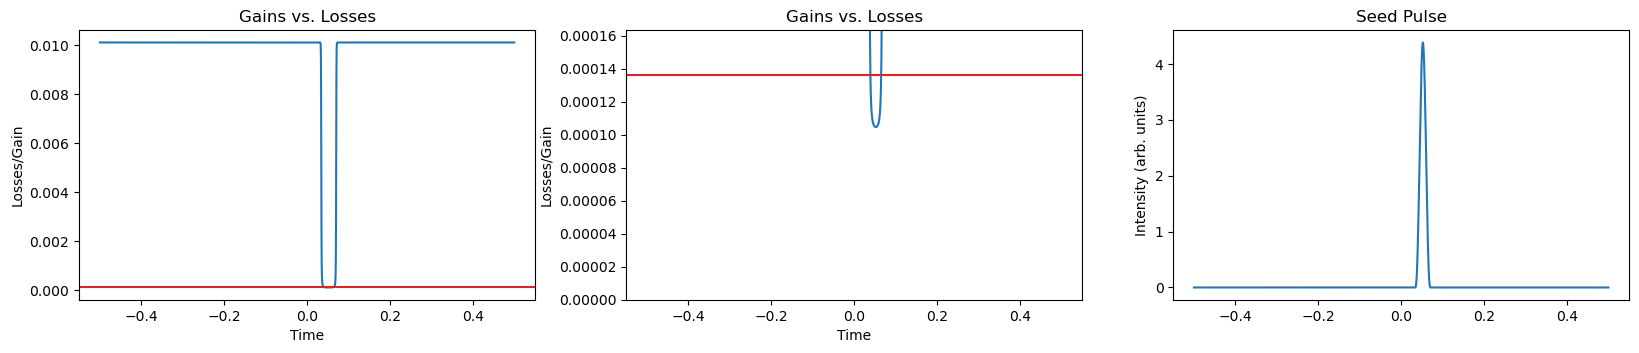

In [30]:
#Calculate gain and satyurable absorber effects
W_pulse = np.trapz(np.abs(A[-1, :])**2)*dt
gain = g0/(1 + W_pulse/W_sat)
losses = l + s0/(1 + np.abs(A[-1, :])**2/I_sat)

# -- Plot: Compare Gain and Loss In Cavity w/ Modulation -- 
fig = plt.figure()
fig.set_size_inches(20, 3.5)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(t, losses)
ax1.axhline(gain, color='tab:red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Losses/Gain')
ax1.set_title('Gains vs. Losses')

ax2.plot(t, losses)
ax2.axhline(gain, color='tab:red')
ax2.set_ylim(0, gain*1.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Losses/Gain')
ax2.set_title('Gains vs. Losses')

ax3.plot(t, np.abs(A[-1, :])**2)
ax2.set_xlabel('Time')
ax3.set_ylabel('Intensity (arb. units)')
ax3.set_title('Seed Pulse')